In [1]:
import warnings

# Turn off all warnings (not recommended unless you're sure)
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.metrics import Precision, Recall

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


2023-08-31 17:12:53.659748: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
data = pd.read_csv("raw_data/data_clean_and_preprocessed_v2.csv")

In [4]:
data = data.sort_values(by='f_ko')

In [5]:
data=data.query("f_pm_01m < 15 ")

In [6]:
data = data.reset_index(drop=True)

In [7]:
data.shape

(64329, 164)

In [8]:
# X_train = train.iloc[:24882]
# X_val = X.iloc[24882:49544]
# X_test = X.iloc[49544:]
# y_train = y.iloc[:24882]
# y_val = y.iloc[24882:49544]
# y_test = y.iloc[49544:]
# backtest_train = backtest.iloc[:24882]
# backtest_val = backtest.iloc[24882:49544]
# backtest_test = backtest.iloc[49544:]

In [9]:
# Split the data chronologically to avoid look-ahead bias:
test_start_date = '2022-08-20 18:45:00'  # max_date - 1 yr
val_start_date = '2022-02-20 18:45:00'  # max_date - 1.5 yrs
# Split the data into test and train
train = data[data['f_ko'] <= val_start_date]
val = data[(data['f_ko'] > val_start_date) & (data['f_ko'] <= test_start_date)]
test = data[data['f_ko'] > test_start_date]
# Split the data into X and y
X_train = train.drop(columns=["f_place", "f_pm_15m", "f_pm_05m", "f_pm_01m", "f_pm_15m_p_back", "f_id", "f_ko"])
X_val = val.drop(columns = ["f_place", "f_pm_15m", "f_pm_05m", "f_pm_01m", "f_pm_15m_p_back", "f_id", "f_ko"])
X_test = test.drop(columns = ["f_place", "f_pm_15m", "f_pm_05m", "f_pm_01m", "f_pm_15m_p_back", "f_id", "f_ko"])
y_train = train["f_place"]
y_val = val["f_place"]
y_test = test["f_place"]
len(X_train), len(X_val), len(X_test), len(y_train), len(y_val), len(y_test)

(24291, 14924, 25114, 24291, 14924, 25114)

In [10]:
X_val

,f_going,average_or_rating_class,above_below_official_rating_class,PreviousPosition,PredictedRank,f_distance,f_class,f_age,f_pace,f_weight,...,f_headgear_TC,f_headgear_TV,f_headgear_V,f_headgear_VC,f_headgear_no_headgear,country_GB,country_IRE,f_dob,f_prb_avg,pred_isp
24291,0.4,0.212308,0.615482,0.161290,0.225806,0.0,0.833333,0.333333,0.8,0.328125,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.47,0.41,0.076923
24292,0.4,0.212308,0.561261,0.064516,0.064516,0.0,0.833333,0.583333,0.9,0.218750,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.42,0.47,0.166667
24293,0.4,0.212308,0.662926,0.129032,0.032258,0.0,0.833333,0.166667,0.5,0.453125,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.40,0.38,0.200000
24294,0.4,0.212308,0.622260,0.225806,0.000000,0.0,0.833333,0.416667,0.4,0.343750,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.35,0.49,0.285714
24295,0.4,0.212308,0.683259,0.161290,0.096774,0.0,0.833333,0.166667,0.4,0.468750,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.40,0.49,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39210,0.4,0.672879,0.582158,0.129032,0.225806,0.0,0.333333,0.416667,0.5,0.250000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.47,0.48,0.066667
39211,0.4,0.672879,0.588935,0.032258,0.096774,0.0,0.333333,0.166667,0.9,0.281250,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.57,0.64,0.153846
39212,0.4,0.672879,0.629601,0.064516,0.064516,0.0,0.333333,0.166667,0.9,0.375000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.41,0.53,0.166667
39213,0.4,0.672879,0.636379,0.064516,0.032258,0.0,0.333333,0.166667,0.7,0.406250,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.36,0.63,0.222222


In [11]:
backtesting= data[data['f_ko'] > test_start_date]

In [12]:
# X_train=X.iloc[:73753]
# X_val=X.iloc[73753:91432]
# X_test=X.iloc[91432:]
# y_train=y.iloc[:73753]
# y_val=y.iloc[73753:91432]
# y_test=y.iloc[91432:]

In [13]:
# pca = PCA()

# # Fit PCA on your data
# pca.fit(X_train)

# # Get explained variance ratio
# explained_variance_ratio = pca.explained_variance_ratio_

# # Calculate cumulative explained variance
# cumulative_variance = np.cumsum(explained_variance_ratio)

# # Plot explained variance ratio
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
# plt.title('Cumulative Explained Variance')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.grid(True)
# plt.show()

In [14]:
pca = PCA(n_components=70)

In [15]:
X_train_pca = pca.fit_transform(X_train)

In [16]:
X_val_pca = pca.transform(X_val)

In [17]:
X_test_pca = pca.transform(X_test)

In [18]:
# def custom_loss(implied_probabilities, bet_amount, threshold=0.06):
#     def loss(y_true, y_pred):
#         # Calculate the potential profit/loss for each prediction
#         bet_placed = y_pred > (implied_probabilities + threshold)
#         profit_loss = tf.where(y_true == 1, tf.where(bet_placed, (implied_probabilities-1) * bet_amount * y_pred, 0)
#                                , tf.where(bet_placed,bet_amount * y_pred, 0))

#         # Calculate the binary cross-entropy loss
#         binary_crossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)(y_true, y_pred)

#         # Combine all loss components
#         custom_loss_value = tf.reduce_mean(binary_crossentropy + profit_loss)

#         return custom_loss_value
#     return loss

In [19]:

def build_model(input_dim):
    model = Sequential()

    # Input layer
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.15))

    # Hidden layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.01))

    model.add(Dense(64, activation='relu'))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.1))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    return model

model = build_model(X_train_pca.shape[1])


2023-08-31 17:13:04.375450: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00005), loss="binary_crossentropy", metrics=[Precision()])

In [21]:

# Define callbacks (optional)
early_stopping = EarlyStopping(patience=20, restore_best_weights=True)


In [22]:

# Train the model
history = model.fit(X_train_pca, y_train, batch_size=16, epochs=1000, validation_data=(X_val_pca, y_val), callbacks=[early_stopping])


Epoch 1/1000
1519/1519 [==============================] - 4s 2ms/step - loss: 0.4815 - precision: 0.1404 - val_loss: 0.4472 - val_precision: 0.0000e+00
Epoch 2/1000
1519/1519 [==============================] - 2s 2ms/step - loss: 0.4441 - precision: 0.0000e+00 - val_loss: 0.4447 - val_precision: 0.0000e+00
Epoch 3/1000
1519/1519 [==============================] - 2s 2ms/step - loss: 0.4416 - precision: 0.0000e+00 - val_loss: 0.4436 - val_precision: 0.0000e+00
Epoch 4/1000
1519/1519 [==============================] - 2s 2ms/step - loss: 0.4406 - precision: 0.0000e+00 - val_loss: 0.4428 - val_precision: 0.0000e+00
Epoch 5/1000
1519/1519 [==============================] - 2s 2ms/step - loss: 0.4392 - precision: 0.0000e+00 - val_loss: 0.4423 - val_precision: 0.0000e+00
Epoch 6/1000
1519/1519 [==============================] - 2s 2ms/step - loss: 0.4376 - precision: 0.0000e+00 - val_loss: 0.4416 - val_precision: 0.0000e+00
Epoch 7/1000
1519/1519 [==============================] - 3s 2ms/ste

In [23]:
y_pred = model.predict(X_test_pca)

785/785 [==============================] - 1s 714us/step


In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

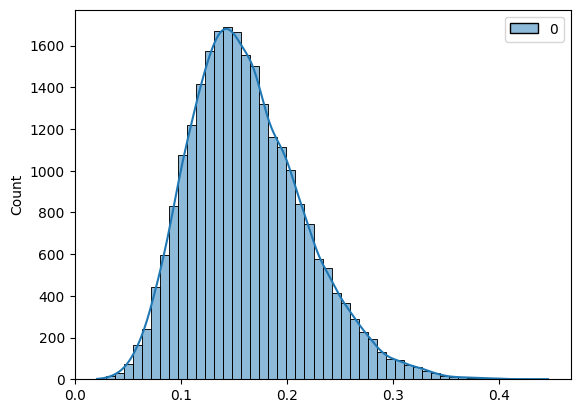

In [25]:
sns.histplot(y_pred, bins=50, kde=True);  # Adjust the number of bins as needed


In [26]:
backtesting["y_pred"]=y_pred

In [27]:
backtesting["probabilities"]=1/backtesting["f_pm_15m"]

In [28]:
backtesting["diff"] = backtesting["y_pred"] - backtesting["probabilities"]

In [29]:
backtesting["diff"].mean()

0.008655008201704464

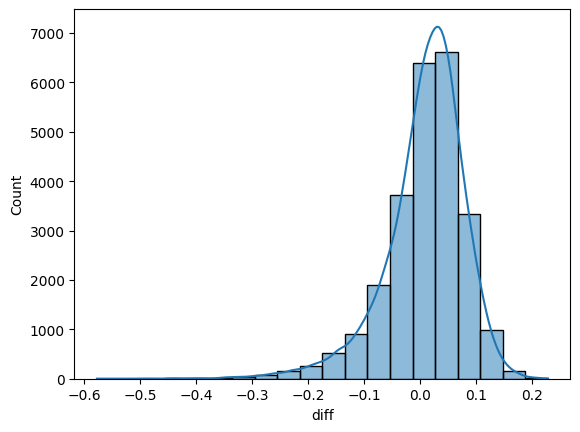

In [30]:
sns.histplot(backtesting["diff"], bins=20, kde=True); 

In [31]:
backtesting["bet_0.1"] = backtesting.apply(lambda row: 1 if row['y_pred'] - row['probabilities'] > 0.1 else 0, axis=1)

In [32]:
backtesting["bet_0.05"] = backtesting.apply(lambda row: 1 if row['y_pred'] - row['probabilities'] > 0.05 else 0, axis=1)

In [33]:
backtesting["bet_0.15"] = backtesting.apply(lambda row: 1 if row['y_pred'] - row['probabilities'] > 0.15 else 0, axis=1)

In [34]:
backtesting["bet_0.05"].value_counts()

0    18092
1     7022
Name: bet_0.05, dtype: int64

In [35]:
backtesting["bet_0.1"].value_counts()

0    23550
1     1564
Name: bet_0.1, dtype: int64

In [36]:
backtesting['bet_0.15'].value_counts()

0    24947
1      167
Name: bet_0.15, dtype: int64

In [37]:
backtesting['bets_placed_0.15'] = backtesting['bet_0.15'].cumsum()
backtesting['bets_placed_0.1'] = backtesting["bet_0.1"].cumsum()
backtesting['bets_placed_0.05'] = backtesting['bet_0.05'].cumsum()

In [38]:
backtesting['profit_0.05']=backtesting['bet_0.05'] * backtesting["f_pm_15m_p_back"]
backtesting['profit_0.1']=backtesting['bet_0.1'] * backtesting["f_pm_15m_p_back"]
backtesting['profit_0.15']=backtesting['bet_0.15'] * backtesting["f_pm_15m_p_back"]

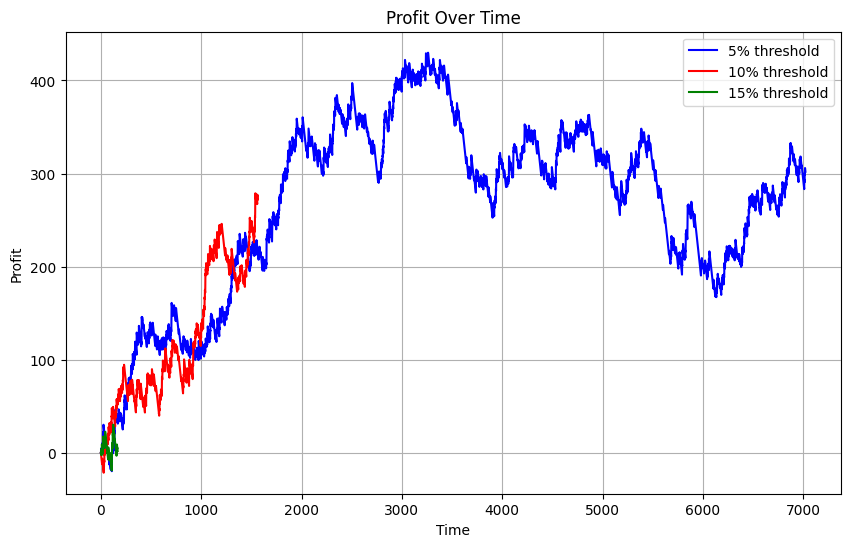

In [39]:
plt.figure(figsize=(10, 6))  # Set the figure size (width, height)
plt.plot(backtesting['bets_placed_0.05'], backtesting['profit_0.05'].cumsum(), linestyle='-', color='b', label='5% threshold')
plt.plot(backtesting['bets_placed_0.1'], backtesting['profit_0.1'].cumsum(), linestyle='-', color='r', label='10% threshold')
plt.plot(backtesting['bets_placed_0.15'], backtesting['profit_0.15'].cumsum(), linestyle='-', color='g', label='15% threshold')
plt.title('Profit Over Time')
plt.xlabel('Time')
plt.ylabel('Profit')
plt.grid(True)

# tick_interval = pd.DateOffset(days=30)  
# start_date = backtesting['f_ko'].min()
# end_date = backtesting['f_ko'].max()
# x_ticks = pd.date_range(start=start_date, end=end_date, freq=tick_interval)
# plt.xticks(x_ticks, x_ticks.strftime('%b %d')) 

# plt.xticks(rotation=45)  


plt.legend()
plt.show()

In [40]:
backtesting['profit_0.05'].cumsum()

39215     -0.00
39216      0.00
39217      0.00
39218     -1.00
39219     -1.00
          ...  
64324    302.94
64325    302.94
64326    302.94
64327    301.94
64328    301.94
Name: profit_0.05, Length: 25114, dtype: float64

In [41]:
backtesting['profit_0.1'].cumsum()

39215     -0.0
39216      0.0
39217      0.0
39218      0.0
39219      0.0
         ...  
64324    272.2
64325    272.2
64326    272.2
64327    272.2
64328    272.2
Name: profit_0.1, Length: 25114, dtype: float64

In [42]:
backtesting['profit_0.15'].cumsum()

39215   -0.00
39216    0.00
39217    0.00
39218    0.00
39219    0.00
         ... 
64324    1.97
64325    1.97
64326    1.97
64327    1.97
64328    1.97
Name: profit_0.15, Length: 25114, dtype: float64

In [43]:
# model.save_weights("model_001")

In [44]:
# pd.set_option('display.max_columns', None)

In [45]:
# X_test['f_ko'] = X_test['f_ko'].astype(int) // 10**9

In [46]:
# X_train['f_ko'] = pd.to_datetime(X_train['f_ko'])

In [47]:
# X_test['f_ko']

In [48]:
# scaler = StandardScaler()

In [49]:
# X_test['f_ko'] = scaler.fit_transform(X_test[['f_ko']])

In [50]:
# X_test['f_ko']

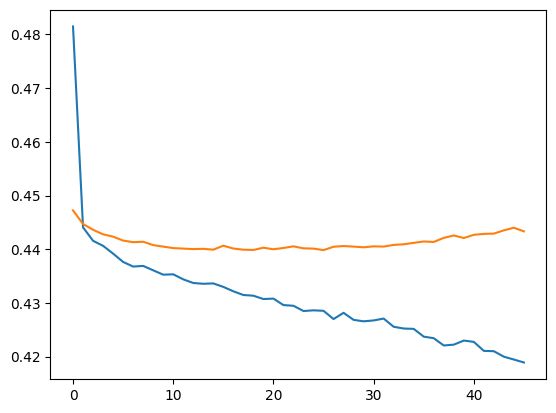

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history["val_loss"])

plt.show()
    